# Практика #1, часть 3. Линейная регрессия в `scikit-learn`

В этом ноутбуке последовательно разберём **линейную регрессию** на практике:

- теория и формулировка задачи;
- генерация синтетических данных;
- разбиение на обучающую и тестовую выборки;
- обучение модели `LinearRegression`;
- интерпретация параметров (коэффициенты и свободный член);
- оценка качества (MSE, RMSE, $R^2$);
- анализ ошибок и визуализации (1D и многомерный случай);
- нормализация признаков и пайплайны;
- параметр `positive=True`;
- **категориальные признаки**: `OneHotEncoder` + `ColumnTransformer`;
- полиномиальные признаки и пример переобучения.


## 1. Импорт библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

def print_regression_metrics(y_true, y_pred, prefix=""):
    """Печать MSE, RMSE и R^2."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MSE:  {mse:.4f}")
    print(f"{prefix}RMSE: {rmse:.4f}")
    print(f"{prefix}R^2:  {r2:.4f}")

## 2. Теория: постановка задачи линейной регрессии

**Задача:** по объекту с признаками $x_1, \dots, x_p$ предсказать вещественное значение $y$.
Мы строим линейную модель вида

$$
\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_p x_p,
$$

где
- $w_0$ — свободный член (intercept),
- $w_1, \dots, w_p$ — коэффициенты (weights).

Пусть у нас есть выборка из $n$ объектов: $(x^{(i)}, y^{(i)})$. Обучение линейной регрессии — это выбор коэффициентов $w$, минимизирующих **среднеквадратичную ошибку (MSE)**:

$$
\text{MSE}(w) = \frac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2.
$$

В `scikit-learn` класс `LinearRegression` по умолчанию решает эту задачу через метод наименьших квадратов.


## 3. Одномерный пример: линейная зависимость с шумом

Начнём с простого случая, когда есть **один признак** $X$ и целевая переменная $y$.

In [3]:
np.random.seed(42)

n_samples = 200
X = np.linspace(0, 10, n_samples).reshape(-1, 1)

true_w0 = 7.0
true_w1 = 3.0
noise = np.random.normal(loc=0.0, scale=2.0, size=n_samples)

y = true_w0 + true_w1 * X[:, 0] + noise

df_1d = pd.DataFrame({"X": X[:, 0], "y": y})
df_1d.head()

,X,y
0,0.000000,7.993428
1,0.050251,6.874225
2,0.100503,8.596885
3,0.150754,10.498321
4,0.201005,7.134708


### 3.1. Визуализация исходных данных

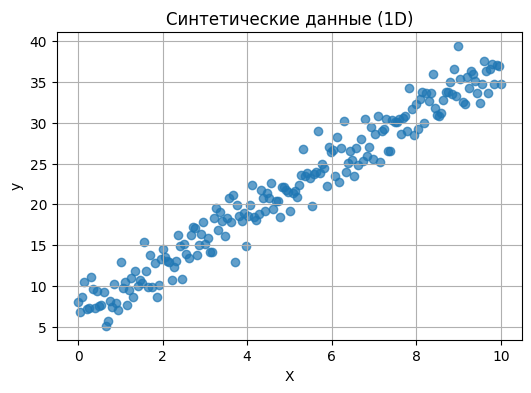

In [4]:
plt.figure()
plt.scatter(df_1d["X"], df_1d["y"], alpha=0.7)
plt.xlabel("X")
plt.ylabel("y")
plt.title("Синтетические данные (1D)")
plt.show()

## 4. Разделение на обучающую и тестовую выборки

Чтобы честно оценить качество модели, делим данные на:

- **обучающую выборку (train)** — для подбора параметров модели;
- **тестовую выборку (test)** — для оценки качества на новых данных.

Используем `train_test_split`.

In [5]:
X_1d = df_1d[["X"]].values
y_1d = df_1d["y"].values

X_train_1d, X_test_1d, y_train_1d, y_test_1d = train_test_split(
    X_1d, y_1d,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train_1d.shape, X_test_1d.shape

((160, 1), (40, 1))

## 5. Базовая линейная регрессия без нормализации

Обучим модель `LinearRegression` в базовой конфигурации.
Важно помнить основные параметры класса:

- `fit_intercept=True` — обучать ли свободный член $w_0$;
- `copy_X=True` — копировать ли матрицу признаков;
- `n_jobs=None` — число потоков;
- `positive=False` — если `True`, коэффициенты $w_j$ будут только неотрицательными.

Начнём с `positive=False` (классический вариант).

In [6]:
linreg_1d = LinearRegression(
    fit_intercept=True,
    copy_X=True,
    n_jobs=None,
    positive=False
)

linreg_1d.fit(X_train_1d, y_train_1d)

print("Оценённый коэффициент w1:", linreg_1d.coef_)
print("Оценённый свободный член w0:", linreg_1d.intercept_)
print("Истинные значения: w1 =", true_w1, ", w0 =", true_w0)

Оценённый коэффициент w1: [3.03370253]
Оценённый свободный член w0: 6.706066205475311
Истинные значения: w1 = 3.0 , w0 = 7.0


### 5.1. Качество и графики для одномерного случая

In [7]:
y_train_pred_1d = linreg_1d.predict(X_train_1d)
y_test_pred_1d = linreg_1d.predict(X_test_1d)

print("Качество на обучающей выборке:")
print_regression_metrics(y_train_1d, y_train_pred_1d, prefix="Train ")

print("\nКачество на тестовой выборке:")
print_regression_metrics(y_test_1d, y_test_pred_1d, prefix="Test ")

Качество на обучающей выборке:
Train MSE:  3.5223
Train RMSE: 1.8768
Train R^2:  0.9585

Качество на тестовой выборке:
Test MSE:  3.0877
Test RMSE: 1.7572
Test R^2:  0.9543


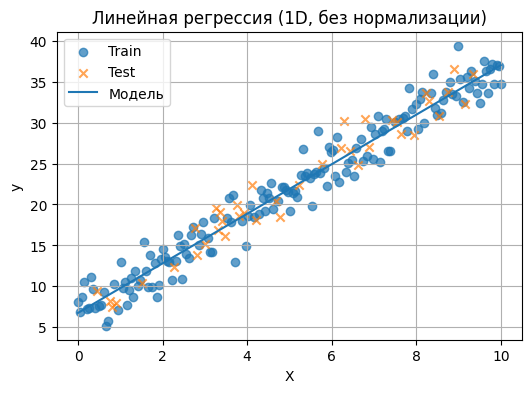

In [8]:
# Линия регрессии + точки train/test
X_line = np.linspace(df_1d["X"].min(), df_1d["X"].max(), 200).reshape(-1, 1)
y_line = linreg_1d.predict(X_line)

plt.figure()
plt.scatter(X_train_1d, y_train_1d, alpha=0.7, label="Train")
plt.scatter(X_test_1d, y_test_1d, alpha=0.7, marker="x", label="Test")
plt.plot(X_line, y_line, label="Модель" )
plt.xlabel("X")
plt.ylabel("y")
plt.title("Линейная регрессия (1D, без нормализации)")
plt.legend()
plt.show()

#### 5.2. Анализ остатков (ошибок)

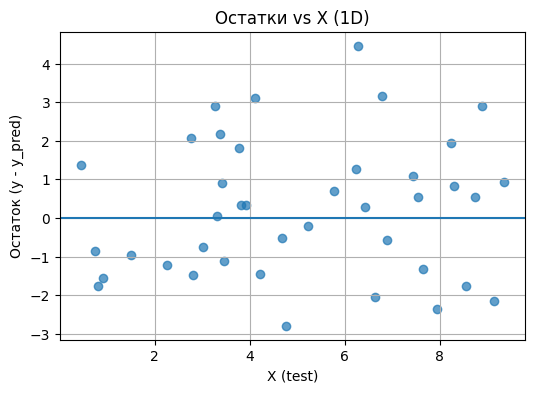

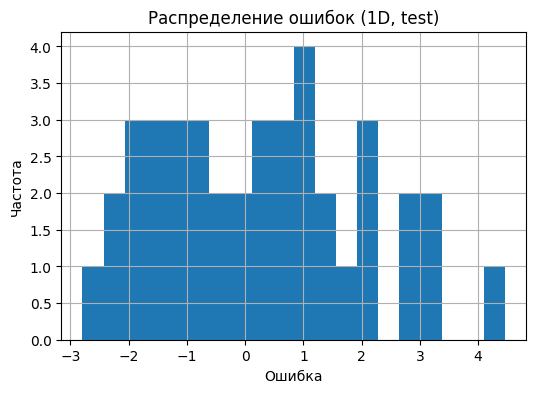

In [13]:
residuals_1d = y_test_1d - y_test_pred_1d

plt.figure()
plt.scatter(X_test_1d, residuals_1d, alpha=0.7)
plt.axhline(0)
plt.xlabel("X (test)")
plt.ylabel("Остаток (y - y_pred)")
plt.title("Остатки vs X (1D)")
plt.show()

plt.figure()
plt.hist(residuals_1d, bins=20)
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.title("Распределение ошибок (1D, test)")
plt.show()

## 6. Нормализация признаков и `Pipeline`

Когда признаки имеют разные масштабы (сантиметры, рубли, годы и т.д.), полезно их **стандартизировать**:

$$
x' = \frac{x - \mu}{\sigma},
$$

где $\mu$ — среднее, $\sigma$ — стандартное отклонение по обучающей выборке.

Для чистой линейной регрессии без регуляризации нормализация не меняет форму прямой, но:

- улучшает численную устойчивость;
- делает коэффициенты более сопоставимыми между собой;
- обязательна при использовании регуляризации (Ridge, Lasso и т.д.).

Правильный способ — включить нормализацию в `Pipeline`, чтобы не допустить утечки информации c теста в train.


In [14]:
pipe_1d_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression(fit_intercept=True, positive=False))
])

pipe_1d_scaled.fit(X_train_1d, y_train_1d)

linreg_scaled_1d = pipe_1d_scaled.named_steps["linreg"]
print("Коэффициент w1 (на стандартизированном X):", linreg_scaled_1d.coef_)
print("Свободный член w0:", linreg_scaled_1d.intercept_)

Коэффициент w1 (на стандартизированном X): [9.02321555]
Свободный член w0: 21.809788718502322


In [15]:
y_train_pred_1d_scaled = pipe_1d_scaled.predict(X_train_1d)
y_test_pred_1d_scaled = pipe_1d_scaled.predict(X_test_1d)

print("Качество (с нормализацией) на обучающей выборке:")
print_regression_metrics(y_train_1d, y_train_pred_1d_scaled, prefix="Train ")

print("\nКачество (с нормализацией) на тестовой выборке:")
print_regression_metrics(y_test_1d, y_test_pred_1d_scaled, prefix="Test ")

Качество (с нормализацией) на обучающей выборке:
Train MSE:  3.5223
Train RMSE: 1.8768
Train R^2:  0.9585

Качество (с нормализацией) на тестовой выборке:
Test MSE:  3.0877
Test RMSE: 1.7572
Test R^2:  0.9543


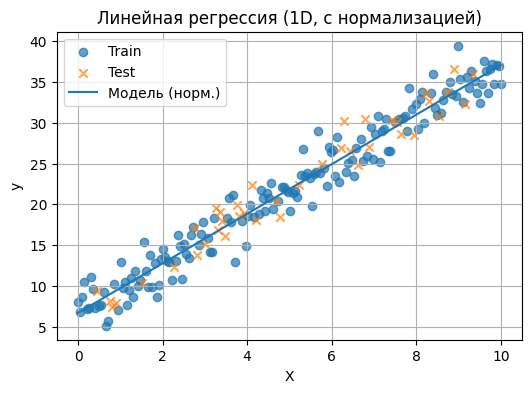

In [16]:
X_line = np.linspace(df_1d["X"].min(), df_1d["X"].max(), 200).reshape(-1, 1)
y_line_scaled = pipe_1d_scaled.predict(X_line)

plt.figure()
plt.scatter(X_train_1d, y_train_1d, alpha=0.7, label="Train")
plt.scatter(X_test_1d, y_test_1d, alpha=0.7, marker="x", label="Test")
plt.plot(X_line, y_line_scaled, label="Модель (норм.)")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Линейная регрессия (1D, с нормализацией)")
plt.legend()
plt.show()

Нормализация руками:

=== Модель на нормализованном X ===
w1_norm = 8.835964219481243
w0_norm = 21.918458069655834

=== Денормализованные коэффициенты ===
w1_back = 3.0456015236954226
w0_back = 6.690450451178718


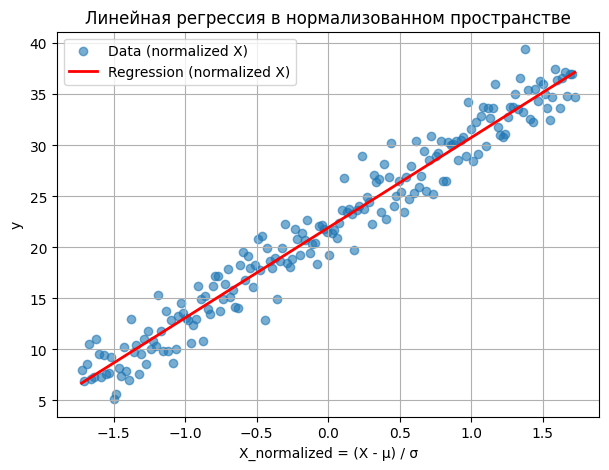

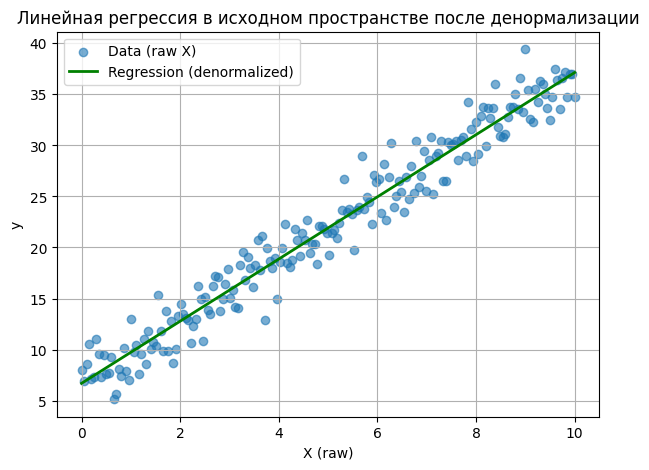

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ============================================================
# 1. Генерация данных
# ============================================================

np.random.seed(42)
n = 200

X = np.linspace(0, 10, n).reshape(-1, 1)
true_w0 = 7
true_w1 = 3
noise = np.random.normal(0, 2, n)

y = true_w0 + true_w1 * X[:, 0] + noise

# ============================================================
# 2. Ручная нормализация X
# ============================================================

mu = X.mean()
sigma = X.std()

X_norm = (X - mu) / sigma  # нормализованный X

# ============================================================
# 3. Обучение модели на НОРМАЛИЗОВАННОМ X
# ============================================================

model_norm = LinearRegression()
model_norm.fit(X_norm, y)

w1_norm = model_norm.coef_[0]
w0_norm = model_norm.intercept_

print("=== Модель на нормализованном X ===")
print("w1_norm =", w1_norm)
print("w0_norm =", w0_norm)

# ============================================================
# 4. Денормализация коэффициентов
#
# Модель обучена на X' = (X - mu)/sigma.
# Чтобы получить коэффициенты для исходного X:
#
#   w1_back = w1_norm / sigma
#   w0_back = w0_norm - mu * (w1_norm / sigma)
# ============================================================

w1_back = w1_norm / sigma
w0_back = w0_norm - mu * (w1_norm / sigma)

print("\n=== Денормализованные коэффициенты ===")
print("w1_back =", w1_back)
print("w0_back =", w0_back)

# ============================================================
# 5. Первый график — РЕГРЕССИЯ В НОРМАЛИЗОВАННОМ ПРОСТРАНСТВЕ
# ============================================================

plt.figure(figsize=(7, 5))

plt.scatter(X_norm, y, alpha=0.6, label="Data (normalized X)")
x_line_norm = np.linspace(X_norm.min(), X_norm.max(), 200).reshape(-1, 1)
y_line_norm = model_norm.predict(x_line_norm)

plt.plot(x_line_norm, y_line_norm, color="red", linewidth=2, label="Regression (normalized X)")
plt.xlabel("X_normalized = (X - μ) / σ")
plt.ylabel("y")
plt.title("Линейная регрессия в нормализованном пространстве")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 6. Второй график — РЕГРЕССИЯ В ИСХОДНОМ ПРОСТРАНСТВЕ
# ============================================================

plt.figure(figsize=(7, 5))

plt.scatter(X, y, alpha=0.6, label="Data (raw X)")

x_line_raw = np.linspace(0, 10, 200)
y_line_raw = w0_back + w1_back * x_line_raw

plt.plot(x_line_raw, y_line_raw, color="green", linewidth=2, label="Regression (denormalized)")
plt.xlabel("X (raw)")
plt.ylabel("y")
plt.title("Линейная регрессия в исходном пространстве после денормализации")
plt.legend()
plt.grid(True)
plt.show()


## 7. Многомерный пример (несколько признаков)

Теперь рассмотрим случай, когда есть три числовых признака:

$$
y = 5 + 2 x_1 - 0.5 x_2 + 0.8 x_3 + \varepsilon.
$$

Сгенерируем данные и обучим линейную регрессию с нормализацией.

In [17]:
np.random.seed(123)

n_samples_multi = 500
X1 = np.random.uniform(0, 10, size=n_samples_multi)
X2 = np.random.uniform(-5, 5, size=n_samples_multi)
X3 = np.random.normal(0, 3, size=n_samples_multi)

true_w_multi = np.array([2.0, -0.5, 0.8])
true_b_multi = 5.0

noise_multi = np.random.normal(0, 1.5, size=n_samples_multi)
y_multi = true_b_multi + true_w_multi[0] * X1 + true_w_multi[1] * X2 + true_w_multi[2] * X3 + noise_multi

df_multi = pd.DataFrame({
    "X1": X1,
    "X2": X2,
    "X3": X3,
    "y": y_multi
})
df_multi.head()

,X1,X2,X3,y
0,6.964692,-2.871685,-0.030098,21.317384
1,2.861393,-1.076959,-2.536933,9.439472
2,2.268515,3.515481,2.734382,12.326654
3,5.513148,-3.723878,-4.123491,16.494479
4,7.194690,3.938654,-1.641197,16.937757


### 7.1. Быстрый взгляд на данные и корреляции

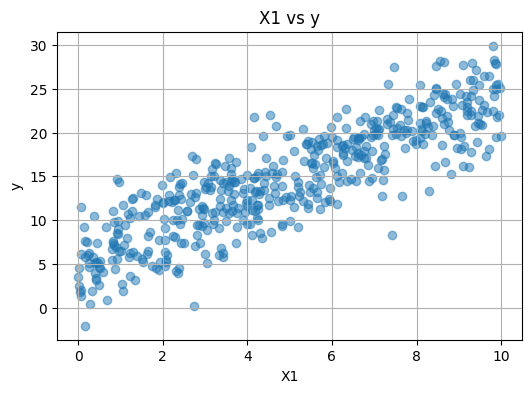

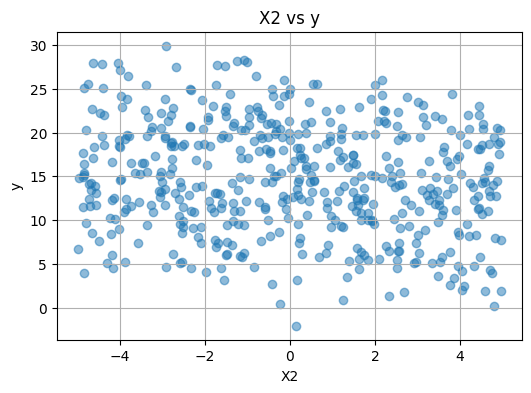

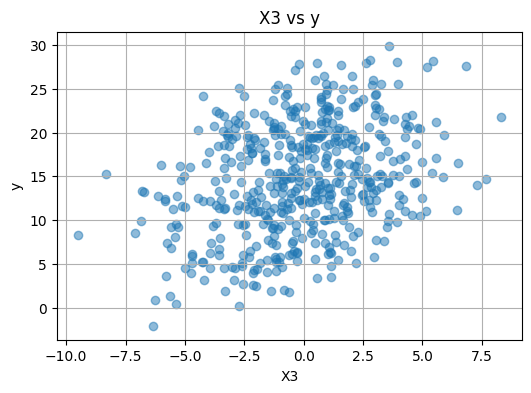

In [18]:
plt.figure()
plt.scatter(df_multi["X1"], df_multi["y"], alpha=0.5)
plt.xlabel("X1")
plt.ylabel("y")
plt.title("X1 vs y")
plt.show()

plt.figure()
plt.scatter(df_multi["X2"], df_multi["y"], alpha=0.5)
plt.xlabel("X2")
plt.ylabel("y")
plt.title("X2 vs y")
plt.show()

plt.figure()
plt.scatter(df_multi["X3"], df_multi["y"], alpha=0.5)
plt.xlabel("X3")
plt.ylabel("y")
plt.title("X3 vs y")
plt.show()

In [19]:
corr = df_multi.corr(numeric_only=True)
corr

,X1,X2,X3,y
X1,1.000000,0.053703,-0.057673,0.868701
X2,0.053703,1.000000,0.036487,-0.166541
X3,-0.057673,0.036487,1.000000,0.321995
y,0.868701,-0.166541,0.321995,1.000000


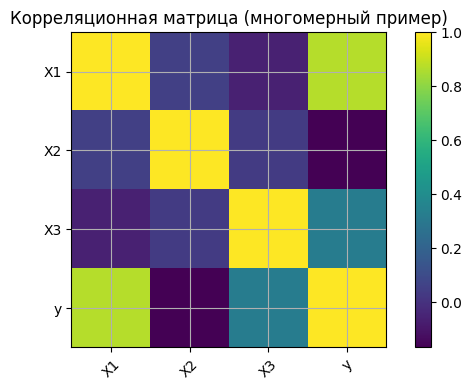

In [20]:
plt.figure()
im = plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(im)
plt.title("Корреляционная матрица (многомерный пример)")
plt.tight_layout()
plt.show()

### 7.2. Обучение модели и оценка качества

In [21]:
X_multi = df_multi[["X1", "X2", "X3"]].values
y_multi_values = df_multi["y"].values

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi_values,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

pipe_multi = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression(fit_intercept=True, positive=False))
])

pipe_multi.fit(X_train_m, y_train_m)

linreg_multi = pipe_multi.named_steps["linreg"]
print("Оценённые коэффициенты:", linreg_multi.coef_)
print("Оценённый свободный член:", linreg_multi.intercept_)

print("\nИстинные коэффициенты:", true_w_multi)
print("Истинный свободный член:", true_b_multi)

Оценённые коэффициенты: [ 5.71942376 -1.45058496  2.38302493]
Оценённый свободный член: 14.666215251704713

Истинные коэффициенты: [ 2.  -0.5  0.8]
Истинный свободный член: 5.0


In [22]:
y_train_m_pred = pipe_multi.predict(X_train_m)
y_test_m_pred = pipe_multi.predict(X_test_m)

print("Качество (многомерный пример) на обучающей выборке:")
print_regression_metrics(y_train_m, y_train_m_pred, prefix="Train ")

print("\nКачество (многомерный пример) на тестовой выборке:")
print_regression_metrics(y_test_m, y_test_m_pred, prefix="Test ")

Качество (многомерный пример) на обучающей выборке:
Train MSE:  2.2562
Train RMSE: 1.5021
Train R^2:  0.9447

Качество (многомерный пример) на тестовой выборке:
Test MSE:  1.6600
Test RMSE: 1.2884
Test R^2:  0.9501


### 7.3. Визуализация предсказаний и ошибок

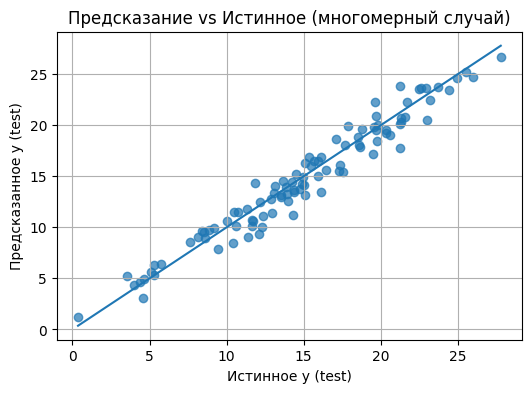

In [23]:
plt.figure()
plt.scatter(y_test_m, y_test_m_pred, alpha=0.7)
min_y = min(y_test_m.min(), y_test_m_pred.min())
max_y = max(y_test_m.max(), y_test_m_pred.max())
plt.plot([min_y, max_y], [min_y, max_y])
plt.xlabel("Истинное y (test)")
plt.ylabel("Предсказанное y (test)")
plt.title("Предсказание vs Истинное (многомерный случай)")
plt.show()

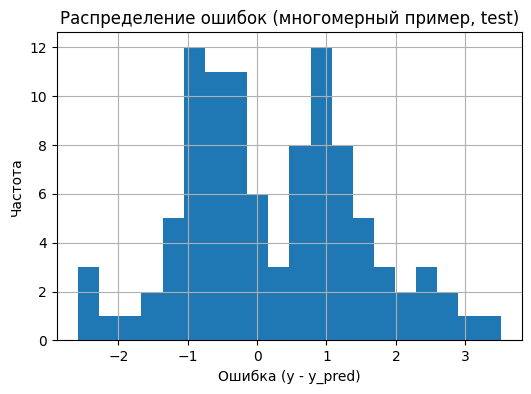

In [24]:
residuals_m = y_test_m - y_test_m_pred

plt.figure()
plt.hist(residuals_m, bins=20)
plt.xlabel("Ошибка (y - y_pred)")
plt.ylabel("Частота")
plt.title("Распределение ошибок (многомерный пример, test)")
plt.show()

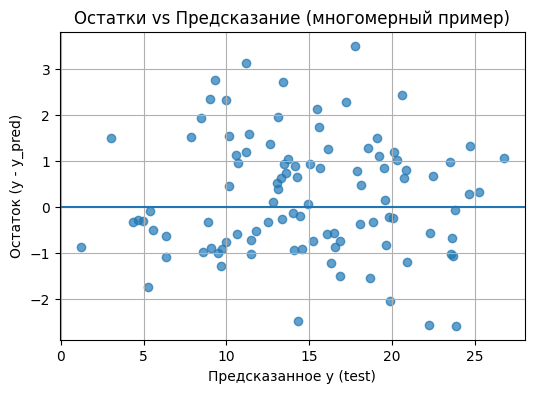

In [25]:
plt.figure()
plt.scatter(y_test_m_pred, residuals_m, alpha=0.7)
plt.axhline(0)
plt.xlabel("Предсказанное y (test)")
plt.ylabel("Остаток (y - y_pred)")
plt.title("Остатки vs Предсказание (многомерный пример)")
plt.show()

## 8. Параметр `positive=True`

Иногда из предметной области известно, что признаки **не могут уменьшать** целевое значение (их вклад только неотрицательный).

В таком случае можно использовать `LinearRegression(positive=True)`, чтобы ограничить коэффициенты $w_j \ge 0$.

Построим пример, где истинные коэффициенты заведомо положительные.

In [26]:
np.random.seed(2024)

n_samples_pos = 400
Z1 = np.random.uniform(0, 10, size=n_samples_pos)
Z2 = np.random.uniform(0, 5, size=n_samples_pos)
Z3 = np.random.uniform(10, 20, size=n_samples_pos)

true_w_pos = np.array([1.5, 0.7, 0.3])
true_b_pos = 2.0

noise_pos = np.random.normal(0, 1.0, size=n_samples_pos)
y_pos = true_b_pos + true_w_pos[0] * Z1 + true_w_pos[1] * Z2 + true_w_pos[2] * Z3 + noise_pos

Z = np.vstack([Z1, Z2, Z3]).T

Z_train, Z_test, y_train_pos, y_test_pos = train_test_split(
    Z, y_pos,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

pipe_pos = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression(fit_intercept=True, positive=True))
])

pipe_pos.fit(Z_train, y_train_pos)

linreg_pos = pipe_pos.named_steps["linreg"]
print("Оценённые коэффициенты (positive=True):", linreg_pos.coef_)
print("Оценённый свободный член:", linreg_pos.intercept_)

print("\nИстинные коэффициенты:", true_w_pos)
print("Истинный свободный член:", true_b_pos)

Оценённые коэффициенты (positive=True): [4.17076373 0.89133331 0.92358572]
Оценённый свободный член: 15.758869092638543

Истинные коэффициенты: [1.5 0.7 0.3]
Истинный свободный член: 2.0


In [27]:
y_train_pos_pred = pipe_pos.predict(Z_train)
y_test_pos_pred = pipe_pos.predict(Z_test)

print("Качество (positive=True) на обучающей выборке:")
print_regression_metrics(y_train_pos, y_train_pos_pred, prefix="Train ")

print("\nКачество (positive=True) на тестовой выборке:")
print_regression_metrics(y_test_pos, y_test_pos_pred, prefix="Test ")

Качество (positive=True) на обучающей выборке:
Train MSE:  1.0378
Train RMSE: 1.0187
Train R^2:  0.9501

Качество (positive=True) на тестовой выборке:
Test MSE:  0.7971
Test RMSE: 0.8928
Test R^2:  0.9600


## 9. Работа с категориальными признаками

Линейная регрессия в `sklearn` умеет работать только с числовыми признаками.
Если в данных есть строки (города, тип объекта, категория товара и т.п.), их нужно преобразовать.

**Неверный подход:** просто закодировать категории числами `0, 1, 2, ...` и подать в линейную регрессию.  
Так мы создаём **фиктивный порядок** между категориями: модель будет считать, что «город 2» больше «города 1» и т.п.

**Правильный подход:** использовать **one-hot encoding** (dummy-переменные):
для каждой категории заводится бинарный признак.

В `sklearn` это делается связкой `ColumnTransformer` + `OneHotEncoder`.


### 9.1. Синтетический пример с городами

In [28]:
np.random.seed(2025)

n_samples_cat = 500

cities = np.random.choice(["Tokyo", "Osaka", "Kyoto"], size=n_samples_cat, p=[0.5, 0.3, 0.2])
area = np.random.uniform(20, 60, size=n_samples_cat)  # площадь
city_effect = {"Tokyo": 40.0, "Osaka": 20.0, "Kyoto": 10.0}

base_price = 100.0
noise_price = np.random.normal(0, 5.0, size=n_samples_cat)

y_price = base_price + 3.0 * area + np.array([city_effect[c] for c in cities]) + noise_price

df_cat = pd.DataFrame({
    "area": area,
    "city": cities,
    "price": y_price
})
df_cat.head()

,area,city,price
0,51.349667,Tokyo,291.897947
1,30.348044,Kyoto,201.009661
2,38.557031,Kyoto,222.340826
3,36.383394,Tokyo,253.297078
4,45.685389,Tokyo,275.975105


In [29]:
df_cat.groupby("city")["price"].mean()

city
Kyoto    233.866597
Osaka    234.599713
Tokyo    262.993046
Name: price, dtype: float64

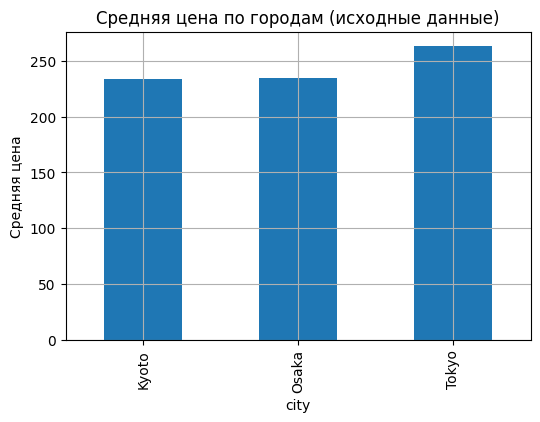

In [30]:
plt.figure()
df_cat.groupby("city")["price"].mean().plot(kind="bar")
plt.ylabel("Средняя цена")
plt.title("Средняя цена по городам (исходные данные)")
plt.show()

### 9.2. Неправильный вариант: прямое числовое кодирование категорий

In [31]:
encoding = {"Tokyo": 0, "Osaka": 1, "Kyoto": 2}
df_wrong = df_cat.copy()
df_wrong["city_code"] = df_wrong["city"].map(encoding)

X_wrong = df_wrong[["area", "city_code"]].values
y_wrong = df_wrong["price"].values

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_wrong, y_wrong,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

linreg_wrong = LinearRegression()
linreg_wrong.fit(X_train_w, y_train_w)

print("Коэффициенты (плохое кодирование):", linreg_wrong.coef_)
print("Intercept:", linreg_wrong.intercept_)

y_test_w_pred = linreg_wrong.predict(X_test_w)
print("\nКачество на тесте (плохое кодирование):")
print_regression_metrics(y_test_w, y_test_w_pred, prefix="Test ")

Коэффициенты (плохое кодирование): [  3.02164412 -15.320433  ]
Intercept: 138.517488939247

Качество на тесте (плохое кодирование):
Test MSE:  29.2728
Test RMSE: 5.4104
Test R^2:  0.9789


Модель как-то отрабатывает, но коэффициент при `city_code` **трудно интерпретировать** и зависит от произвольной нумерации городов.

Перейдём к корректному варианту.


### 9.3. Правильный вариант: One-Hot Encoding + ColumnTransformer

In [32]:
num_features = ["area"]
cat_features = ["city"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features)  # drop="first" чтобы избежать коллинеарности
    ]
)

pipe_cat = Pipeline([
    ("prep", preprocess),
    ("linreg", LinearRegression())
])

X_cat = df_cat[["area", "city"]]
y_cat = df_cat["price"].values

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cat, y_cat,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

pipe_cat.fit(X_train_c, y_train_c)

linreg_cat = pipe_cat.named_steps["linreg"]
print("Intercept:", linreg_cat.intercept_)

Intercept: 230.2003945709305


In [33]:
# Восстановим имена признаков после трансформации
ohe = pipe_cat.named_steps["prep"].named_transformers_["cat"]
ohe_feature_names = list(ohe.get_feature_names_out(cat_features))

feature_names = num_features + ohe_feature_names
coefs = linreg_cat.coef_

coef_table = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs
})
coef_table

,feature,coef
0,area,34.986472
1,city_Osaka,10.740747
2,city_Tokyo,29.596950


In [34]:
y_test_c_pred = pipe_cat.predict(X_test_c)
print("Качество (one-hot кодирование) на тестовой выборке:")
print_regression_metrics(y_test_c, y_test_c_pred, prefix="Test ")

Качество (one-hot кодирование) на тестовой выборке:
Test MSE:  24.9857
Test RMSE: 4.9986
Test R^2:  0.9820


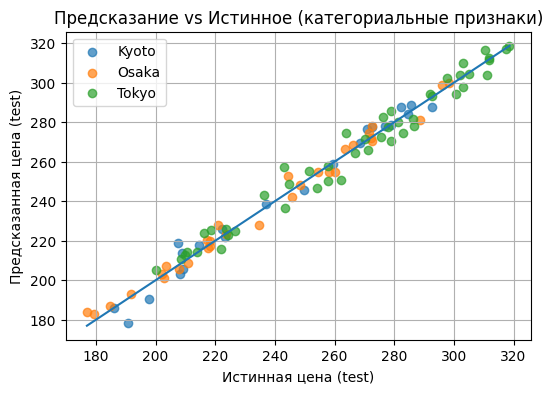

In [35]:
# Предсказание vs истинное, с разными маркерами для городов
plt.figure()
cities_test = X_test_c["city"].values

for city in np.unique(cities_test):
    mask = cities_test == city
    plt.scatter(y_test_c[mask], y_test_c_pred[mask], alpha=0.7, label=city)

min_y = min(y_test_c.min(), y_test_c_pred.min())
max_y = max(y_test_c.max(), y_test_c_pred.max())
plt.plot([min_y, max_y], [min_y, max_y])

plt.xlabel("Истинная цена (test)")
plt.ylabel("Предсказанная цена (test)")
plt.title("Предсказание vs Истинное (категориальные признаки)")
plt.legend()
plt.show()

## 10. Полиномиальные признаки и переобучение

Линейная модель может быть применена не только к исходным признакам $x$, но и к их полиномиальным комбинациям:
$x, x^2, x^3, \dots$.

Если мы добавляем полиномиальные признаки, модель становится **нелинейной по x**, но остаётся **линейной по параметрам w**.

В `sklearn` за это отвечает класс `PolynomialFeatures`.

Покажем на примере:

- модель степени 1 (обычная прямая);
- модель степени 15 (очень гибкая, склонна к переобучению).

In [44]:
from sklearn.preprocessing import PolynomialFeatures

# Берём те же 1D данные
X_poly = X_1d
y_poly = y_1d

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_poly, y_poly,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

def make_poly_pipeline(degree):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("linreg", LinearRegression())
    ])

pipe_deg1 = make_poly_pipeline(degree=1)
pipe_deg15 = make_poly_pipeline(degree=15)

pipe_deg1.fit(X_train_p, y_train_p)
pipe_deg15.fit(X_train_p, y_train_p)

,steps,"[('scaler', ...), ('poly', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,degree,15
,interaction_only,False
,include_bias,False
,order,'C'


In [45]:
# Оценим качество
y_train_pred_d1 = pipe_deg1.predict(X_train_p)
y_test_pred_d1 = pipe_deg1.predict(X_test_p)

y_train_pred_d15 = pipe_deg15.predict(X_train_p)
y_test_pred_d15 = pipe_deg15.predict(X_test_p)

print("Степень 1 (обычная линейная регрессия):")
print_regression_metrics(y_train_p, y_train_pred_d1, prefix="Train ")
print_regression_metrics(y_test_p, y_test_pred_d1, prefix="Test  ")

print("\nСтепень 15 (очень гибкая модель):")
print_regression_metrics(y_train_p, y_train_pred_d15, prefix="Train ")
print_regression_metrics(y_test_p, y_test_pred_d15, prefix="Test  ")

Степень 1 (обычная линейная регрессия):
Train MSE:  3.5223
Train RMSE: 1.8768
Train R^2:  0.9585
Test  MSE:  3.0877
Test  RMSE: 1.7572
Test  R^2:  0.9543

Степень 15 (очень гибкая модель):
Train MSE:  3.2449
Train RMSE: 1.8013
Train R^2:  0.9618
Test  MSE:  3.1747
Test  RMSE: 1.7818
Test  R^2:  0.9530


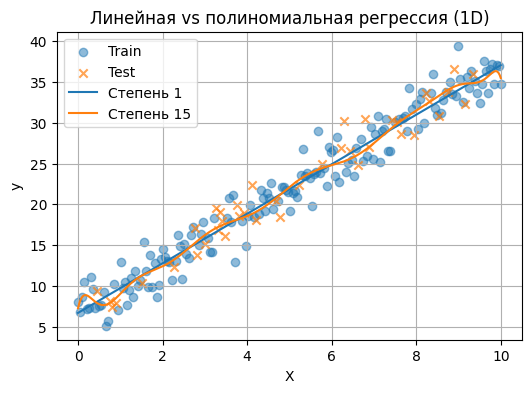

In [46]:
# Визуализация прямой (deg=1) и кривой (deg=15)
X_plot = np.linspace(df_1d["X"].min(), df_1d["X"].max(), 400).reshape(-1, 1)
y_plot_d1 = pipe_deg1.predict(X_plot)
y_plot_d15 = pipe_deg15.predict(X_plot)

plt.figure()
plt.scatter(X_train_p, y_train_p, alpha=0.5, label="Train")
plt.scatter(X_test_p, y_test_p, alpha=0.7, marker="x", label="Test")
plt.plot(X_plot, y_plot_d1, label="Степень 1" )
plt.plot(X_plot, y_plot_d15, label="Степень 15" )
plt.xlabel("X")
plt.ylabel("y")
plt.title("Линейная vs полиномиальная регрессия (1D)")
plt.legend()
plt.show()

## 11. Итоги

В этом ноутбуке мы:

1. Вспомнили постановку задачи линейной регрессии и MSE.
2. Построили простую модель на одном признаке, обучили и визуализировали прямую регрессии.
3. Разделили данные на train/test и посчитали метрики (MSE, RMSE, $R^2$).
4. Исследовали остатки и увидели, как они распределены.
5. Добавили нормализацию через `StandardScaler` и обернули всё в `Pipeline`.
6. Рассмотрели многомерный пример с несколькими признаками, обучили модель и построили графики "предсказание vs истинное" и распределения ошибок.
7. Разобрали параметр `positive=True` и ситуацию, когда известен знак коэффициентов.
8. Подробно рассмотрели работу с категориальными признаками: неправильное кодирование vs правильное `OneHotEncoder` + `ColumnTransformer` + `Pipeline`.
9. Показали использование полиномиальных признаков и пример переобучения при высокой степени полинома.

Дальнейшие шаги на будущее:

- линейные модели с регуляризацией (Ridge, Lasso, ElasticNet);
- кросс-валидация и подбор гиперпараметров (`GridSearchCV`, `RandomizedSearchCV`);
- анализ важности признаков и интерпретируемость моделей на реальных данных.
